## Homework Assignment Part 1
---

- Applicant: Kasra Azizbaigi
- email: kasra.azizbaigi@gmail.com

### Project Overview
---

Part 1 of the homework assignment is a Time Series Analysis task on Power Consumption (MWH) spanning from the years 2010 to 2018. 

What is Time Series Analysis?!

- Time series analysis is a branch of statistics and data science that deals with the study and modelling of data points ordered by time. 
- It involves exploring temporal patterns, detecting trends, seasonality, and cyclic behaviours, assessing autocorrelation, and building predictive models to forecast future values. 
- This field employs statistical methods, such as autoregressive integrated moving average (ARIMA) models, exponential smoothing, and advanced machine learning techniques like recurrent neural networks (RNNs) and Long Short-Term Memory (LSTM) networks to extract valuable insights and make predictions from time-ordered data. 
- Time series analysis finds applications in disciplines like econometrics, meteorology, epidemiology, and finance to capture and understand temporal dependencies and inform decision-making.

Table of context:

- **Exploratory Data Analysis:**
    - Load Libraries and the dataset
    - Duplicate and Missing values
    - Feature Creation
    - Seasonal Decomposition
- **Model Development**
    - ACF & PACF Plots
    - Train and Test Splits
    - Base Model Architecture
    - ML Model Architecture
- **Conclusions and Future Directions**

### Exploratory Data Analysis
---

#### Load libraries and the dataset:

Here, I will import the required libraries, load the dataset into a pandas data frame and organize the data frame.

##### Load libraries:

In [1]:
# Import required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Statmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML Models
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Libraries Settings
plt.style.use('ggplot')
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")

##### Load and organize the dataset:

In [2]:
# Load the dataset
df_raw = pd.read_csv('power_data.csv')
df_raw.set_index('Datetime', inplace=True)

# Drop the first column
df_raw = df_raw.iloc[:, 1:]

# Sort Data
df_raw.sort_index(inplace=True)

# first 5 rows
df_raw.head()

,Power_MWH
Datetime,
2010-01-01 00:00:00,31647.0
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0


In [4]:
# Print Dataset Info
print('Dataset Info: ')
print('Total Rows: ', df_raw.shape[0])
print('Total Columns: ', df_raw.shape[1])
print('\n')

# Print Dataset Detail
print('Dataset Details: ')
df_raw.info()
print('\n')

# Print Index Dtype
print('Index Dtype: ', df_raw.index.dtype)

Dataset Info: 
Total Rows:  75255
Total Columns:  1


Dataset Details: 
<class 'pandas.core.frame.DataFrame'>
Index: 75255 entries, 2010-01-01 00:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Power_MWH  75255 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB


Index Dtype:  object


In [5]:
# Convert index Dtype to datetime
df_raw.index = pd.to_datetime(df_raw.index)

# Print Index Dtype
print('Index Dtype: ', df_raw.index.dtype)

Index Dtype:  datetime64[ns]


In [6]:
# Describe numerical values
print(df_raw.describe())
print('\n')
print('Conclusions: ')
print('The minimum of power consumption is: 14544 (MWH)')
print('The maximum of power consumption is: 61646 (MWH)')
print('The mean of power consumption is: 14544 (MWH)')
print('The std of power consumption is: 6503 (MWH)')
print('The median of power consumption is: 30838 (MWH)')

          Power_MWH
count  75255.000000
mean   31729.893575
std     6503.002099
min    14544.000000
25%    27233.500000
50%    30838.000000
75%    35353.500000
max    61646.000000


Conclusions: 
The minimum of power consumption is: 14544 (MWH)
The maximum of power consumption is: 61646 (MWH)
The mean of power consumption is: 14544 (MWH)
The std of power consumption is: 6503 (MWH)
The median of power consumption is: 30838 (MWH)


#### Duplicate and Missing values:

In preparation for analyzing the dataset at an hourly frequency (Hour), I encountered an issue related to duplicate rows within the index column. To address this, I initiated a comprehensive assessment of the dataset to identify and handle any instances of duplicated values. Following the successful handling of duplicates, I proceeded to address missing entries within the index column to ensure a complete and uninterrupted hourly time series analysis.

##### Duplicates:

In [7]:
# Return all duplicates
duplicate_index = df_raw.index[df_raw.index.duplicated(keep='first')]
duplicates_rows = df_raw[df_raw.index.duplicated(keep=False)]
print(duplicates_rows)
print('There are a total of 4 rows with duplicates.')

                     Power_MWH
Datetime                      
2014-11-02 02:00:00    22935.0
2014-11-02 02:00:00    23755.0
2015-11-01 02:00:00    21567.0
2015-11-01 02:00:00    21171.0
2016-11-06 02:00:00    21692.0
2016-11-06 02:00:00    20795.0
2017-11-05 02:00:00    20666.0
2017-11-05 02:00:00    21236.0
There are a total of 4 rows with duplicates.


There are usually two options to handle duplicates:
1. Aggregating duplicates: Aggregating duplicates will retain information but change the data
2. removing duplicates: removing duplicates simplifies the data but might result in some loss of information

Since duplicate values are close to each other, I decided to compute the mean of two values.

In [8]:
# Aggregate the duplicates
df_raw = df_raw.groupby(df_raw.index).agg({'Power_MWH': 'mean'})
corrected_rows = df_raw.loc[duplicate_index]
print(corrected_rows)
print('Duplicates were successfully aggregated!')

                     Power_MWH
Datetime                      
2014-11-02 02:00:00    23345.0
2015-11-01 02:00:00    21369.0
2016-11-06 02:00:00    21243.5
2017-11-05 02:00:00    20951.0
Duplicates were successfully aggregated!


In [9]:
# Set DatetimeIndex Frequency
df_raw = df_raw.asfreq('H')
frequency = df_raw.index.freq
print(f'The frequency has changed to: {frequency}')

The frequency has changed to: <Hour>


##### Missings:

In [10]:
missings = df_raw.isna().sum()
print('Number of missing values for Power_MWH is: ', missings[0])

Number of missing values for Power_MWH is:  14


Depending on the nature of the data there are multiple ways to take care of missing values such as:

1. Dropping Missing Values
2. Filling Missing Values with mean or specified value
3. Forward or Backward Fill
4. Interpolation
5. Imputation with Machine Learning Models
6. etc.

In the case of time series and continues data, a better choice is using Interpolation. This method estimate missing values by interpolating between known values.

In [11]:
# interpolate Missing Values
df_raw['Power_MWH'] = df_raw['Power_MWH'].interpolate(limit_area='inside', limit=None)

In [12]:
missings = df_raw.isna().sum()
print('Number of missing values for Power_MWH is: ', missings[0])

Number of missing values for Power_MWH is:  0


##### Visualize the data:

After completing data cleaning and preparation, the dataset can be effectively visualized by plotting power consumption against hourly data points.

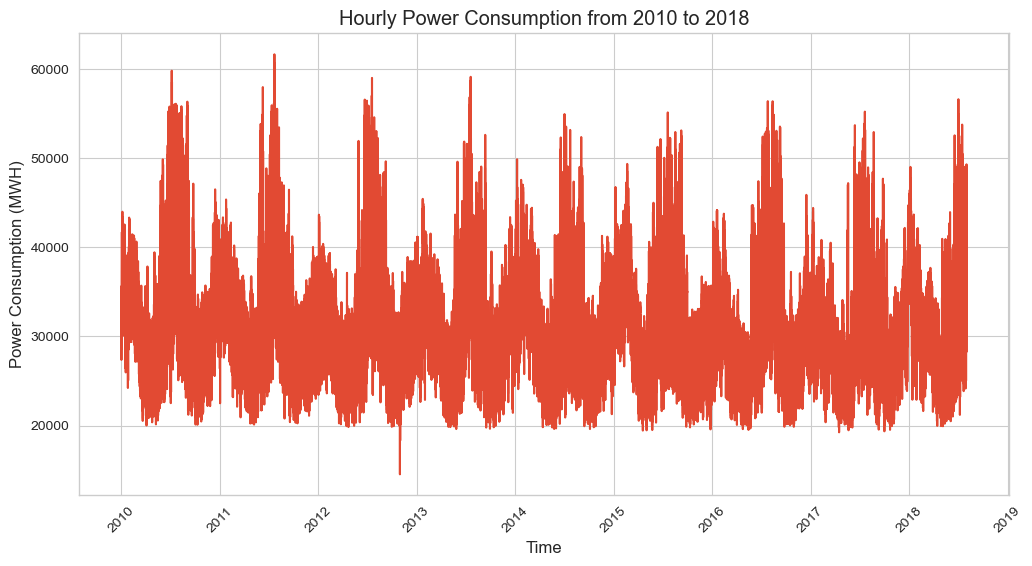

In [13]:
# Create a line plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_raw.index, df_raw['Power_MWH'])
plt.title('Hourly Power Consumption from 2010 to 2018')
plt.ylabel('Power Consumption (MWH)')
plt.xlabel('Time')
plt.xticks(rotation=45) 
plt.show()

#### Feature Creation:

The above plot provides valuable insights into the seasonality of the data on hourly power consumption from 2010 to 2018. However, to gain a more comprehensive understanding of data seasonality and identify underlying patterns that can be leveraged for model development, a set of additional temporal features will be extracted. These features will encompass daily, weekly, monthly, and other temporal associations, strengthening the foundation for time series analysis.

The below features can help us in identifying more patterns:

1. Year
2. Month
3. Day of the Month
4. Hour
5. Day of the Week
6. Quarter
7. Day of the Year
8. Week of the Year
9. Weekly Moving Average
10. Monthly Moving Average
11. Yearly Moving Average
12. Time of the Day (e.g. Night, Morning, Afternoon, Evening)

* Moving Average can help smooth out noise and highlight trends!

In [14]:
# Creating new features
def feature_creation(df, label=None):
    df['Date'] = df.index
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfMonth'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['WeeklyMovingAverage'] = df['Power_MWH'].rolling(window=7*24).mean()
    df['MonthlyMovingAverage'] = df['Power_MWH'].rolling(window=30*24).mean()
    df['QuarterlyMovingAverage'] = df['Power_MWH'].rolling(window=120*24).mean()
    df['TimeOfDay'] = pd.cut(df['Date'].dt.hour, 
                             bins=[0, 6, 12, 18, 24], 
                             labels=['Night', 
                                     'Morning', 
                                     'Afternoon', 
                                     'Evening'], right=False)
    df.drop('Date', axis=1, inplace=True)

    X = df[['Year','Month','DayOfMonth','Hour','DayOfWeek',
           'Quarter','DayOfYear','WeekOfYear', 'WeeklyMovingAverage', 
           'MonthlyMovingAverage', 'QuarterlyMovingAverage']]
    
    if label:
        y = df[label]
        return X, y
    return df

df = feature_creation(df_raw)
df.tail()

,Power_MWH,Year,Month,DayOfMonth,Hour,DayOfWeek,Quarter,DayOfYear,WeekOfYear,WeeklyMovingAverage,MonthlyMovingAverage,QuarterlyMovingAverage,TimeOfDay
Datetime,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,2018,8,2,20,3,3,214,31,35900.238095,36195.288889,31417.425347,Evening
2018-08-02 21:00:00,43256.0,2018,8,2,21,3,3,214,31,35892.583333,36189.683333,31421.079514,Evening
2018-08-02 22:00:00,41552.0,2018,8,2,22,3,3,214,31,35886.119048,36184.191667,31424.460417,Evening
2018-08-02 23:00:00,38500.0,2018,8,2,23,3,3,214,31,35881.500000,36178.723611,31427.404514,Evening
2018-08-03 00:00:00,35486.0,2018,8,3,0,4,3,215,31,35879.976190,36173.370833,31429.887500,Night


##### Visualize Yearly data:

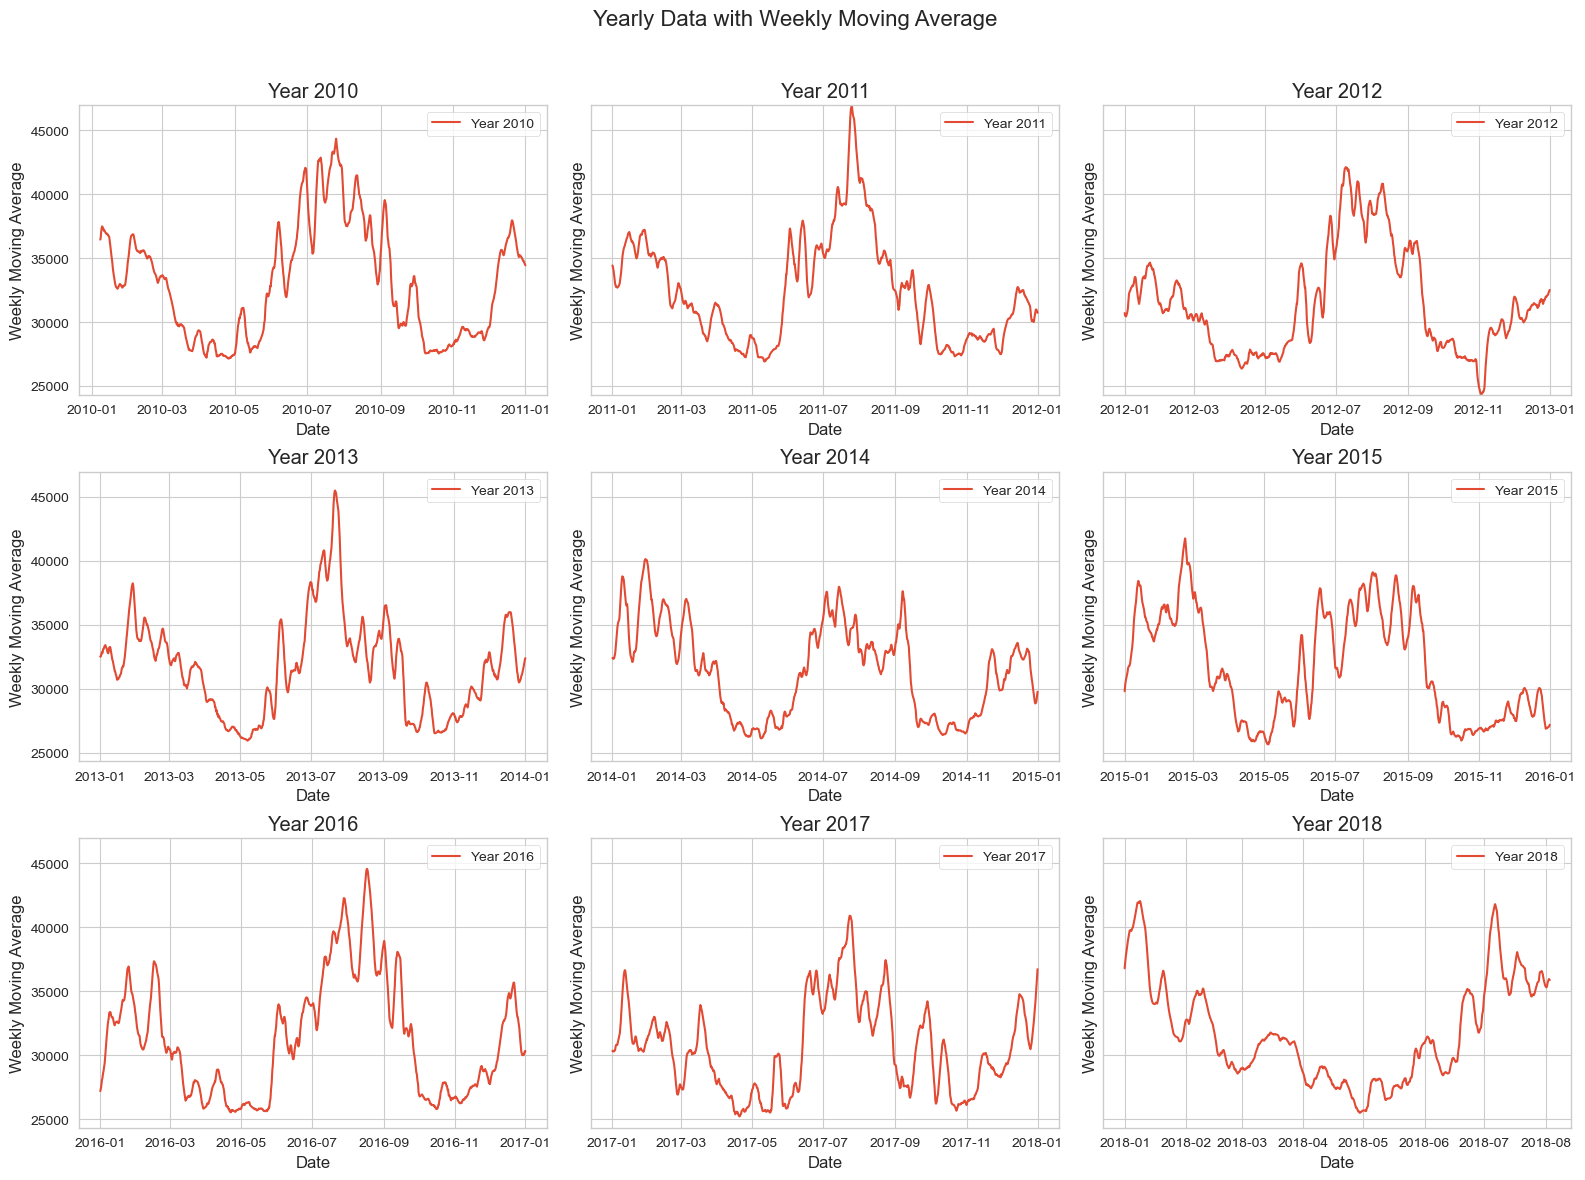

In [16]:
# Calculate the minimum and maximum values in the entire dataset
global_min = df['WeeklyMovingAverage'].min()
global_max = df['WeeklyMovingAverage'].max()

# Get unique years
num_years = df['Year'].nunique()

# Set up the subplots with shared y-axes
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
fig.suptitle('Yearly Data with Weekly Moving Average', fontsize=16)

for i, year in enumerate(df['Year'].unique()):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    year_data = df[df['Year'] == year]
    weekly_moving_average = year_data['WeeklyMovingAverage']

    ax.plot(year_data.index, weekly_moving_average, label=f'Year {year}')
    ax.set_ylim(global_min, global_max)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Moving Average')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()


Yearly power consumption exhibits a consistent pattern across multiple years, characterized by a peak in energy demand during the middle of the year, coinciding with the summer season. This is a typical trend observed in most years. However, it's noteworthy that in the years 2014 and 2015, a notable deviation from this pattern occurred, with the peak in power consumption occurring earlier, during the winter season. Such an anomaly is attributed to extreme cold weather conditions during those years. Interestingly, a similar deviation is also evident in the years 2014, 2015, 2017 and 2018, indicating the influence of unique climatic factors on energy consumption trends, specifically during summer. This observation underscores the impact of external environmental variables on the energy consumption landscape, and it warrants further investigation into the underlying causes.

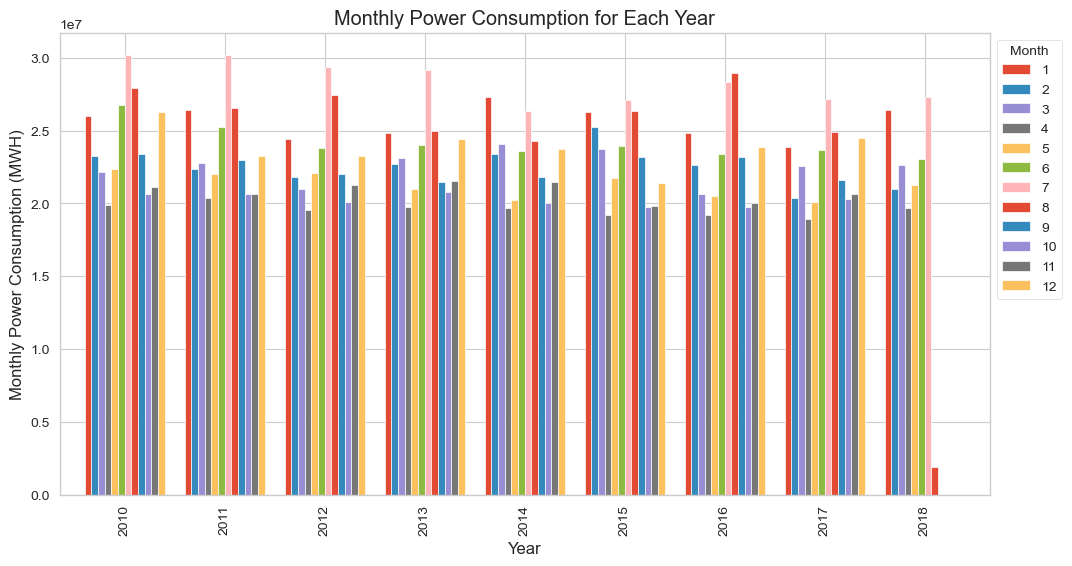

In [17]:
# Group the data by Year and Month and calculate the sum of Power_MWH for each group
monthly_data = df.groupby(['Year', 'Month'])['Power_MWH'].sum().unstack()

# Create a bar plot with years on the x-axis and months as the legend
ax = monthly_data.plot(kind='bar', figsize=(12, 6), width=0.8)  
plt.ylabel('Monthly Power Consumption (MWH)')
plt.title('Monthly Power Consumption for Each Year')
plt.legend(title='Month', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


The presented plot offers a comprehensive overview of monthly power consumption patterns throughout the year. It provides valuable insights into the dynamics of power usage, highlighting distinct variations across different months.

The analysis reveals that power consumption exhibits remarkable stability during specific periods, notably in April, October, and November. During these months, the power consumption remains relatively consistent from year to year.

Conversely, other months such as February, July, and August showcase a more fluctuating pattern, with power consumption levels varying depending on the year.

These nuanced trends in power consumption can be further examined and analyzed in the subsequent graphs, allowing for a more detailed understanding of the underlying factors and potential opportunities for optimization.

##### Visualize Daily data:

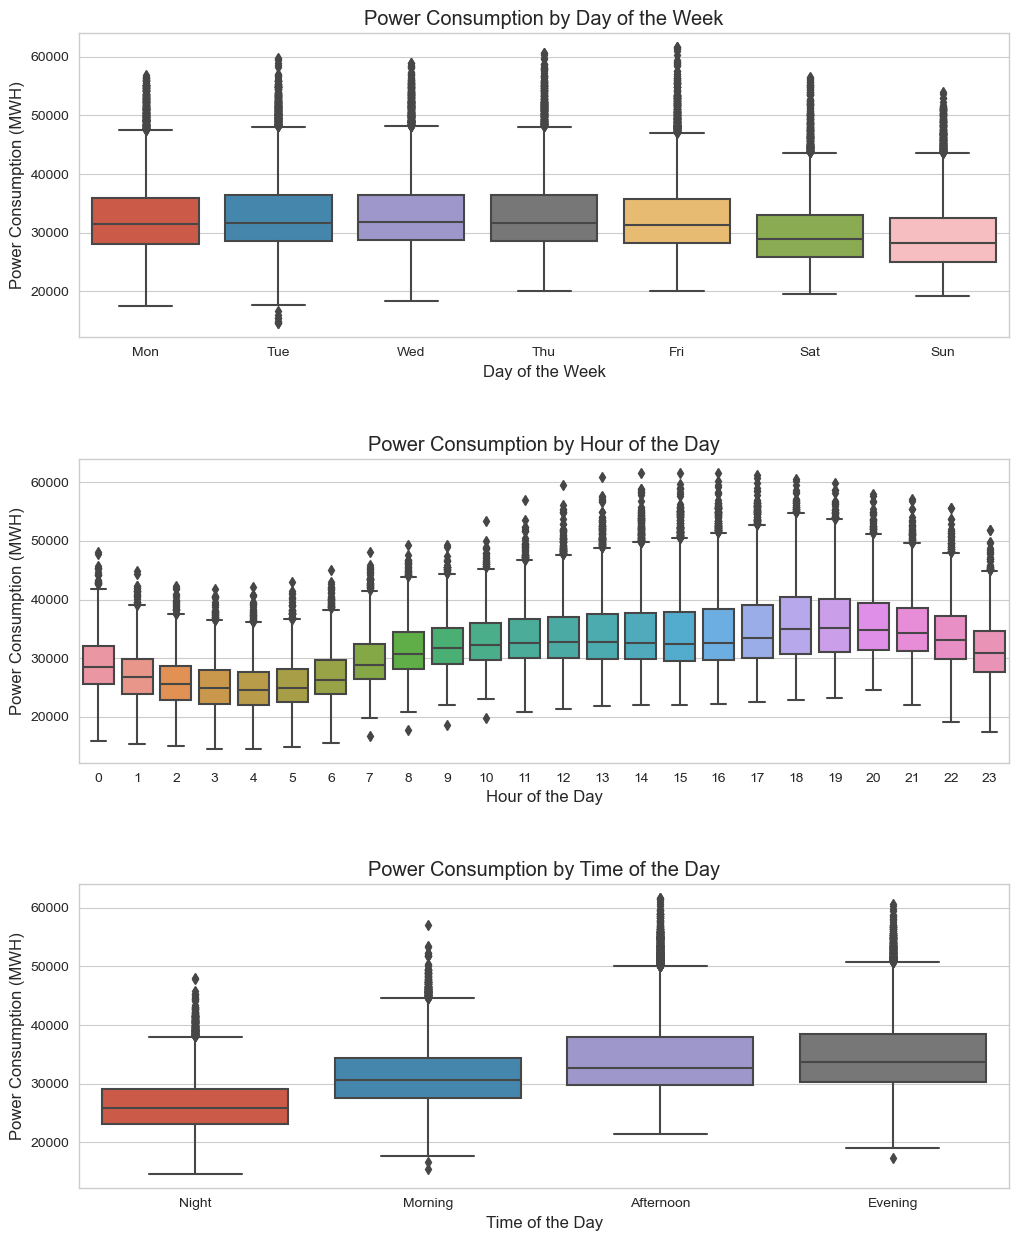

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.subplots_adjust(hspace=0.4)

# Box plot for power consumption based on day of the week
sns.boxplot(x='DayOfWeek', y='Power_MWH', data=df, ax=axes[0])
axes[0].set_title('Power Consumption by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Power Consumption (MWH)')
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0].set_xticklabels(day_labels)

# Box plot for power consumption based on hour
sns.boxplot(x='Hour', y='Power_MWH', data=df, ax=axes[1])
axes[1].set_title('Power Consumption by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Power Consumption (MWH)')

# Box plot for power consumption based on time of the day
sns.boxplot(x='TimeOfDay', y='Power_MWH', data=df, ax=axes[2])
axes[2].set_title('Power Consumption by Time of the Day')
axes[2].set_xlabel('Time of the Day')
axes[2].set_ylabel('Power Consumption (MWH)')

plt.show()

The series of box plots presented above offer valuable insights into the patterns of power consumption based on different temporal factors. The analysis reveals several noteworthy observations:

- Weekdays vs. Weekends: Power consumption exhibits a discernible contrast between weekdays and weekends. Weekdays demonstrate higher power consumption, which can be attributed to the operational demands of businesses and industrial facilities. In contrast, weekends register lower power consumption, aligning with the reduced activity and lower energy demand during these periods.

- Hourly Patterns: The data showcases distinct hourly fluctuations in power consumption. The lowest levels of energy usage are consistently observed at 4 AM during the 'Night' hours, suggesting a period of reduced demand when most individuals are asleep and businesses are dormant. In contrast, the highest power consumption is consistently recorded during the 'Afternoon' hours, peaking around 3 PM. This uptrend continues into the 'Evening' hours, and the demand gradually declines after 8 PM.

These insights into temporal variations in power consumption provide a valuable understanding of the impact of factors such as business operations, daily routines, and industrial activities on energy usage.

##### Visualize Quarterly data:

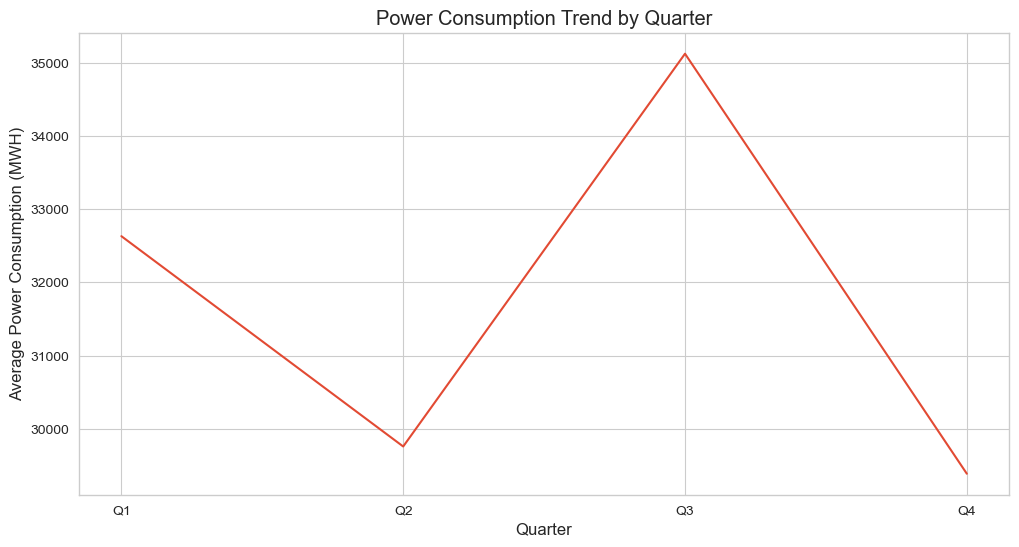

In [19]:
quarterly_data = df.groupby('Quarter')['Power_MWH'].mean()

# Create a line plot to visualize the trend in Quarter data
plt.figure(figsize=(12, 6))
sns.lineplot(x=quarterly_data.index, y=quarterly_data.values)
plt.title('Power Consumption Trend by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Power Consumption (MWH)')
plt.xticks(range(1, 5), ['Q1', 'Q2', 'Q3', 'Q4'])
plt.show()


Analyzing the quarterly data across Q1, Q2, Q3, and Q4 reveals notable patterns in power consumption. Specifically, it is evident that power consumption is substantially higher during the third quarter (Q3) and moderately elevated during the first quarter (Q1). This observation underscores a distinct seasonality in power demand, with the peak occurring in Q3 and a secondary high in Q1.

##### Visualize the effect of Moving Average on data visualization:

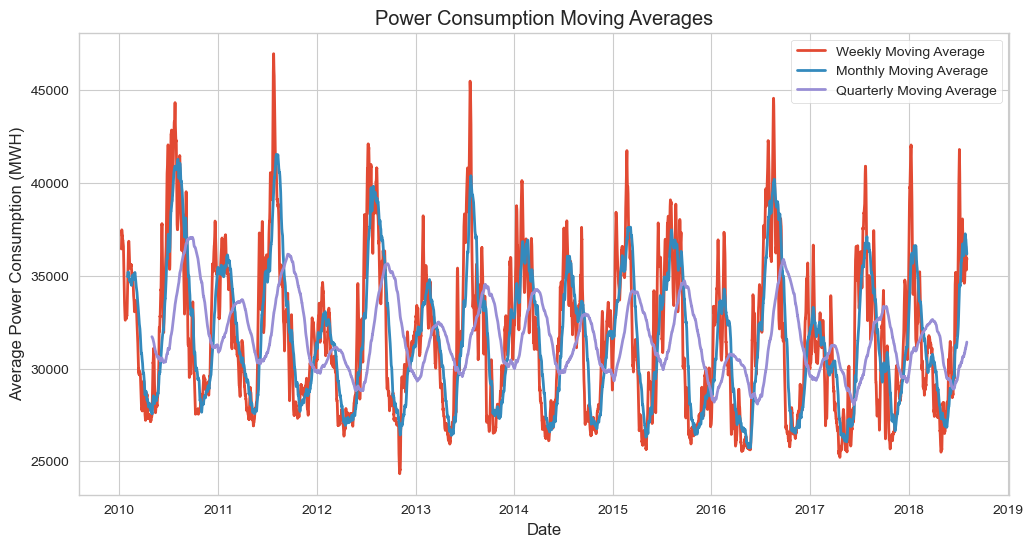

In [20]:
# Analyse the effect of Noise reduction in using Moving average on Time Series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['WeeklyMovingAverage'], label='Weekly Moving Average', linewidth=2)
plt.plot(df.index, df['MonthlyMovingAverage'], label='Monthly Moving Average', linewidth=2)
plt.plot(df.index, df['QuarterlyMovingAverage'], label='Quarterly Moving Average', linewidth=2)

plt.title('Power Consumption Moving Averages')
plt.xlabel('Date')
plt.ylabel('Average Power Consumption (MWH)')
plt.legend()
plt.grid(True)
plt.show()


Employing moving averages to mitigate noise in the data strengthens these insights. The use of moving averages provides a smoothed representation of power consumption trends over the years, reaffirming the recurring pattern. While there may be subtle variations in the exact levels of consumption from year to year, the overarching pattern of increased demand in Q3 and elevated demand in Q1 remains consistently evident.

#### Seasonal Decomposition:

Seasonal decomposition is a statistical technique used to break down a time series data into its underlying components. These components typically include:

1. Trend: The long-term, systematic movement or direction in the data. It represents the overall pattern or tendency in the time series. Trends can be increasing, decreasing, or stable over time.

2. Seasonal: The periodic and repetitive patterns that occur within a time series. These patterns typically repeat over fixed intervals, such as daily, weekly, monthly, or annually. Seasonal components capture the seasonality or cyclic behavior in the data.

3. Residual (or Error): The remaining variation in the data after removing the trend and seasonal components. This component represents the noise or irregular fluctuations in the time series that cannot be attributed to the trend or seasonality.

The main purpose of seasonal decomposition is to better understand the time series data and isolate the various components for analysis and forecasting. It can help in identifying patterns, detecting outliers, and making predictions by modeling each component separately.

Two common methods for performing seasonal decomposition are:

1. Additive Decomposition: In this method, the original time series is assumed to be the sum of the trend, seasonal, and residual components. It's used when the magnitude of the seasonal fluctuations does not depend on the level of the time series.

2. Multiplicative Decomposition: In this method, the original time series is assumed to be the product of the trend, seasonal, and residual components. It's used when the magnitude of the seasonal fluctuations is proportional to the level of the time series.

##### Additive vs Multiplicative Decomposition:

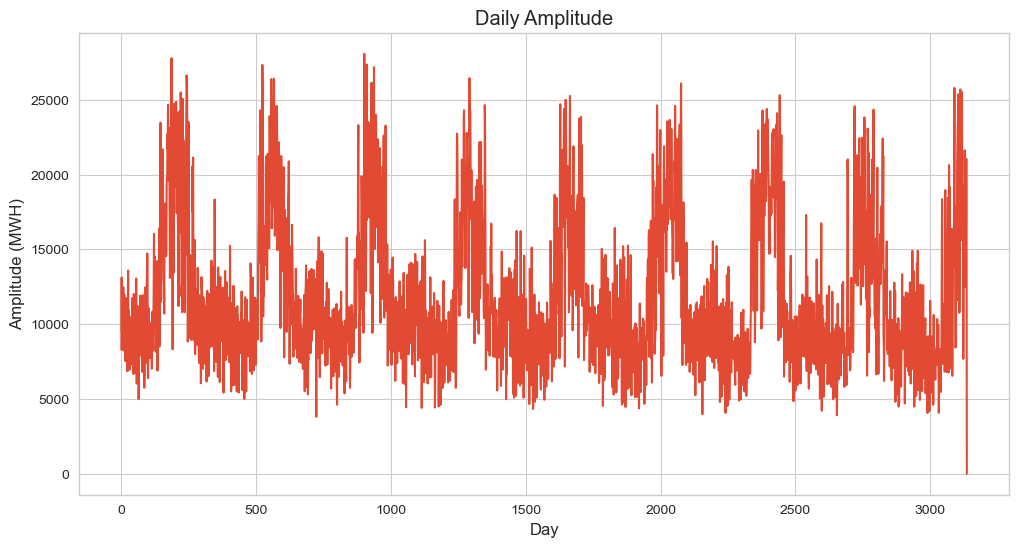

In [21]:
# Calculate the maximum and minimum values for 'Power_MWH' by day of year
max_daily_vals = df.groupby(['Year', 'DayOfYear'])['Power_MWH'].max()
min_daily_vals = df.groupby(['Year', 'DayOfYear'])['Power_MWH'].min()

# Calculate the daily amplitude
daily_amp = max_daily_vals - min_daily_vals

# Plot the daily amplitude
plt.figure(figsize=(12, 6)) 
plt.plot(daily_amp.values)
plt.xlabel('Day')
plt.ylabel('Amplitude (MWH)')
plt.title('Daily Amplitude')
plt.show()


Upon analyzing the presented graph, it becomes evident that variations in the time series' magnitude correspond to corresponding changes in the magnitude of the seasonal decomposition. As a result of this observation, it is reasonable to conclude that the multiplicative decomposition method is a more appropriate choice for addressing this particular problem.

##### Seasonal Decomposition plots:

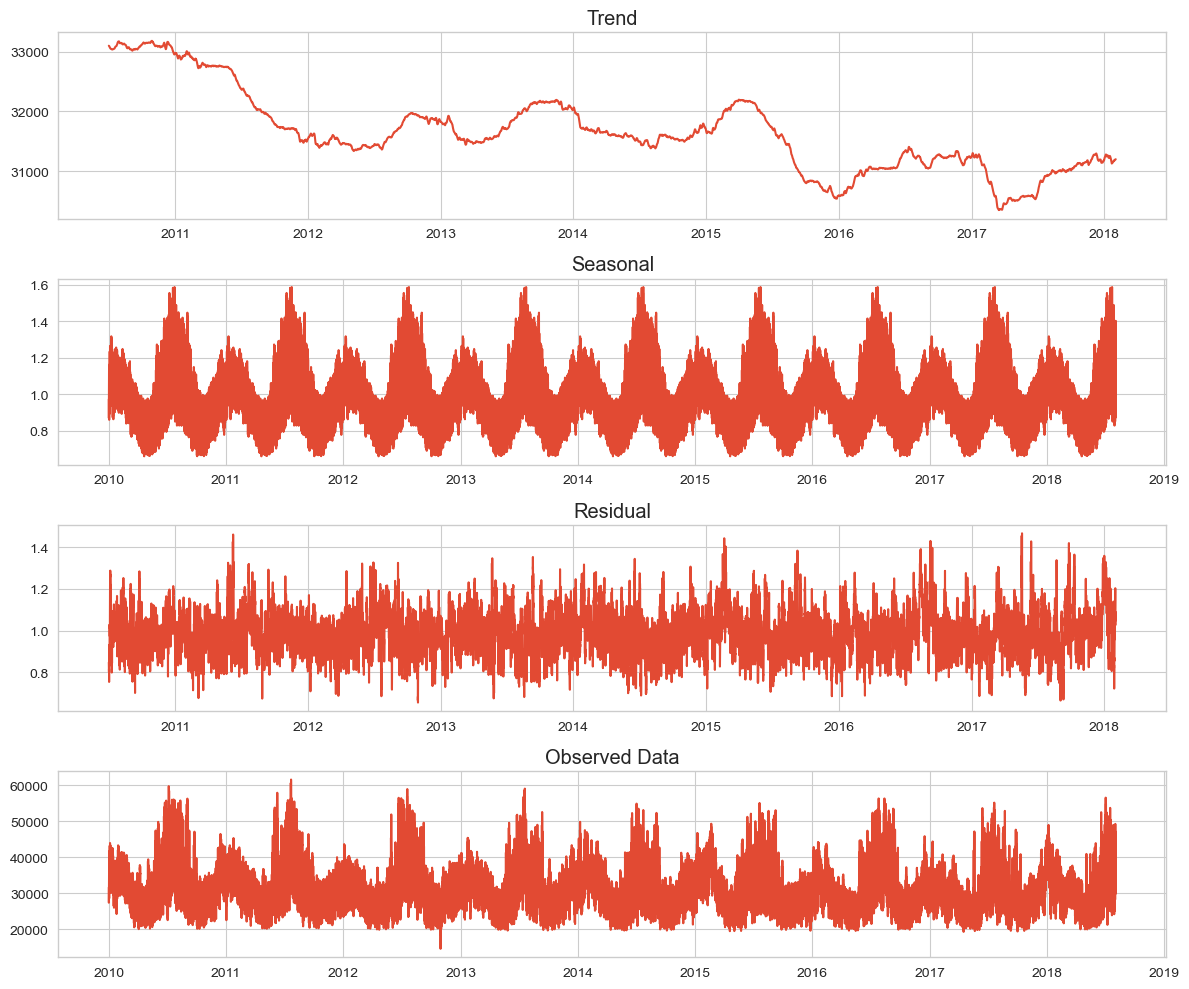

In [22]:
df['Power_MWH'] = df['Power_MWH'].astype(float) 

# Perform seasonal decomposition with a known annual period
mult_decomp = seasonal_decompose(df['Power_MWH'], model='multiplicative', period=365*24)

plt.figure(figsize=(12, 10))  
# Plot the trend component
plt.subplot(411)
plt.plot(mult_decomp.trend)
plt.title('Trend')

# Plot the seasonal component
plt.subplot(412)
plt.plot(mult_decomp.seasonal)
plt.title('Seasonal')

# Plot the residual component
plt.subplot(413)
plt.plot(mult_decomp.resid)
plt.title('Residual')

# Plot the Observed Data
plt.subplot(414)
plt.plot(df['Power_MWH'])
plt.title('Observed Data')

plt.tight_layout()
plt.show()


##### Stationary vs Non-Stationary:

In the context of time series analysis, stationarity refers to a property of the data that remains relatively constant over time. A stationary time series is one in which the statistical properties, such as the mean and variance, do not change with time. The identification of stationarity is a crucial step in time series analysis, because many time series forecasting methods assume stationarity or work best when the data is stationary.

Statistical tests like the Augmented Dickey-Fuller (ADF) test are used to determine whether a time series is stationary. If the data is non-stationary, appropriate transformations (e.g., differencing or detrending) may be applied to make it stationary before modeling and forecasting.

In [23]:
# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(df['Power_MWH'])

# Extract and print ADF Statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]
print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'p-value: {p_value:.4f}')

# Interpret the ADF test result
if p_value <= 0.05:
    print('Result: Data is stationary (reject the null hypothesis)')
else:
    print('Result: Data is non-stationary (fail to reject the null hypothesis)')


ADF Statistic: -13.2178
p-value: 0.0000
Result: Data is stationary (reject the null hypothesis)


The observed stationarity of the data represents a significant advantage in the context of time series analysis. Stationary data, characterized by consistent statistical properties over time, simplifies the modeling and forecasting process. By remaining relatively constant in terms of mean and variance, the data allows for more reliable and straightforward application of various time series analysis techniques, ultimately enhancing the accuracy and interpretability of results.

### Model Development:
---

The BL model I will propose is based on Autoregressive Integrated Moving Average (ARIMA) model which is a widely used time series forecasting technique that combines three key components: 

1. The autoregressive (AR) component: The autoregressive component captures the relationship between a data point and its past values,
2. The differencing (I) component: The differencing component stabilizes the data by removing trends,
3. Moving average (MA) component: The moving average component models the influence of past forecast errors.

ARIMA is designed to model and predict time series data by accounting for underlying trends, seasonality, and autocorrelation. By adjusting the order of these components, ARIMA can provide accurate forecasts for a wide range of time series data, making it an essential tool in time series analysis and prediction.

There is also a similar model with the same components but also incormporating the seasonality components called Seasonal Autoregressive Integrated Moving Average (SRIMA). The Seasonal Autoregressive Integrated Moving Average (SARIMA) model, an extension of the Autoregressive Integrated Moving Average (ARIMA) framework, introduces additional seasonal components to address time series data characterized by pronounced seasonality. What distinguishes SARIMA from ARIMA is the incorporation of seasonal orders, enabling the model to accurately capture and forecast data with recurring patterns that occur at fixed time intervals, such as daily, monthly, or yearly cycles. 

Identifying the value of each component is essential in proposing a strong baseline model. In what follows, I will investigate these components and propose a baseline model:

- The order of an autoregressive component AR(n) in a time series model signifies the number of preceding values that are utilized to predict future values. This component captures the relationship between the current value and its historical observations.
- The order of differencing I(n) indicates the number of prior values subtracted from the current value to induce stationarity in the time series. It plays a crucial role in stabilizing the data by removing trends and non-stationarity.
- The order of a moving average component MA(n) signifies the count of prior residual errors incorporated into the regression task to predict future values. This component models the influence of past forecast errors and helps capture the random noise in the time series.
- The order of a seasonal component S(n) represents the number of preceding values that collectively create recurring patterns in the time series. It is employed to identify and model seasonality, where data exhibits repetitive patterns over fixed intervals.

In our case I have already investigated some of these components.

1. Conducting an Augmented Dickey-Fuller (ADF) test has indicated that the dataset is stationary, implying that the differencing (I) component may not be necessary. However, practical experimentation is advisable to confirm this. Differencing can enhance the stability of the time series and mitigate residual trends or seasonality. In practice, it is not unusual for time series data to derive benefits from some level of differencing, even when the ADF test initially suggests stationarity, as this approach can assist in capturing subtle patterns and reducing any remaining seasonality.

2. To Investigate AR and MA components, one can use Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots which are fundamental tools in time series analysis that help to understand and model the relationships and patterns within a time series. They provide insights into the autocorrelation structure of the data, which is the correlation between the series and its past lags. 

    - The ACF measures the correlation between a time series and its own past values at different lags. The ACF is primarily used to identify the order of MA (moving average) components in a time series model. In the ACF plot, significant autocorrelations at a specific lag indicate a potential MA component of that order. The autocorrelation is high at the lag where the MA component may be influencing the data.
    - The PACF is a measure of the direct relationship between an observation and its lags while controlling for the effect of intermediate lags. It reveals the partial correlation between the current value and its past lags, effectively eliminating the influence of shorter lags. The PACF is primarily used to identify the order of AR (autoregressive) components in a time series model. In the PACF plot, significant partial autocorrelations at a specific lag suggest a potential AR component of that order. The partial autocorrelation represents the direct relationship between the current value and its past lags while controlling for the effect of intermediate lags.

#### ACF & PACF Plots:

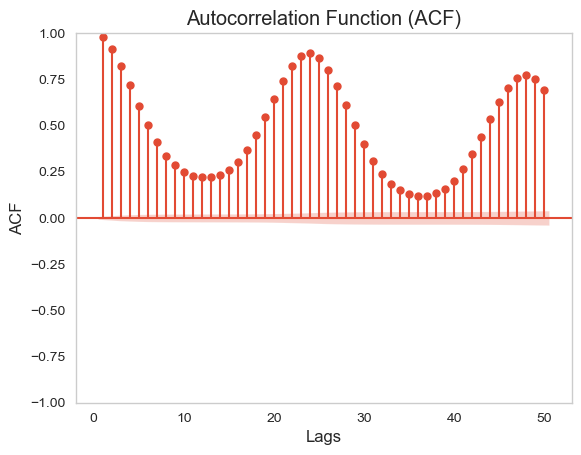

In [24]:
plot_acf(df['Power_MWH'], lags=50, title='Autocorrelation Function (ACF)', zero=False)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid()  
plt.show()

Upon thorough examination of the Autocorrelation Function (ACF) plot, it becomes evident that no significant autocorrelations exist at specific lags. Consequently, it can be inferred that the inclusion of a Moving Average (MA) component may not offer substantial utility in the context of time series analysis for this particular task. This observation suggests that factors other than lagged observations may be more relevant in explaining the dynamics of the time series under investigation.

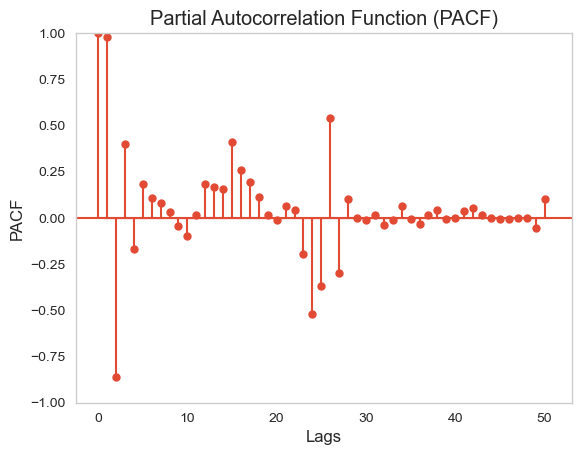

In [25]:
plot_pacf(df['Power_MWH'], lags=50, title='Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid()  
plt.show()

Upon in-depth analysis of the Partial Autocorrelation Function (PACF), a notable and significant autocorrelation emerges at a 24-hour lag. This finding suggests that an Autoregressive (AR) component of order 24, AR(24), would be well-suited for capturing the autoregressive dynamics of the time series. However, it's essential to acknowledge that the computational demands of an AR(24) model can be prohibitively high.

Additionally, a distinct daily seasonality pattern is discernible within the dataset. Given this identified daily seasonality with a periodicity of 24 hours, it is more practical and computationally efficient to opt for a Seasonal Autoregressive Integrated Moving Average (SARIMA) model. The SARIMA model incorporates this daily seasonality as its seasonal component and provides a balance between capturing the desired patterns and managing computational complexity, making it a more appropriate choice for time series analysis in this context.

#### Train & Test Splits:

In [26]:
# Train & Test splits
train_start_date = datetime(2017, 1, 1)
train_end_date = datetime(2018, 8, 2)


# Split the data into training and testing
train_series = df.loc[(df.index >= train_start_date) & (df.index < train_end_date), 'Power_MWH']
test_series = df.loc[(df.index >= train_end_date), 'Power_MWH']

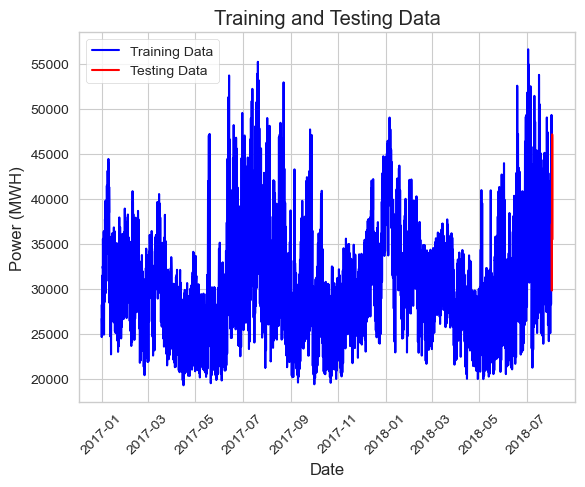

In [27]:
# Plot train and test splits
plt.plot(train_series.index, train_series, color='blue', label='Training Data')
plt.plot(test_series.index, test_series, color='red', label='Testing Data')


plt.xlabel('Date')
plt.ylabel('Power (MWH)')
plt.title('Training and Testing Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.show()

#### Base Model Architecture:

Upon the careful consideration of model components, I have arrived at the configuration of my base model, which is a Seasonal Autoregressive Integrated Moving Average with:

- p (AR order): 1
- d (differencing order): 0 or 1
- q (MA order): 0
- P (seasonal AR order): 1
- D (seasonal differencing order): 0 or 1
- Q (seasonal MA order): 0
- s (seasonal period): 24

To facilitate the evaluation of time series models with various component configurations, I have encapsulated this model architecture within the evaluate_time_series_model function. This function offers the flexibility to select the base model type, such as ARIMA or SARIMA, and define the specific model components.

In assessing the performance of these models, I employ two key evaluation metrics:

- Root Mean Squared Error (RMSE): RMSE is an error metric that quantifies the average squared error between predicted and actual values. Its advantage lies in providing an interpretable error measure in the same units as the underlying data.

- R-squared (R2) Score: R2 serves as a metric to gauge the proportion of explained variance, offering insights into the goodness of fit of a regression model. Higher R2 values indicate a better model fit to the data.

These metrics collectively aid in the comprehensive evaluation of time series models, enabling me to select the most appropriate model configuration for accurate forecasting and model performance assessment.

Completed iteration 1/25
Completed iteration 2/25
Completed iteration 3/25
Completed iteration 4/25
Completed iteration 5/25
Completed iteration 6/25
Completed iteration 7/25
Completed iteration 8/25
Completed iteration 9/25
Completed iteration 10/25
Completed iteration 11/25
Completed iteration 12/25
Completed iteration 13/25
Completed iteration 14/25
Completed iteration 15/25
Completed iteration 16/25
Completed iteration 17/25
Completed iteration 18/25
Completed iteration 19/25
Completed iteration 20/25
Completed iteration 21/25
Completed iteration 22/25
Completed iteration 23/25
Completed iteration 24/25
Completed iteration 25/25
Root Mean Squared Error (MSE): 316.222
R Squared Score (r2): 0.997


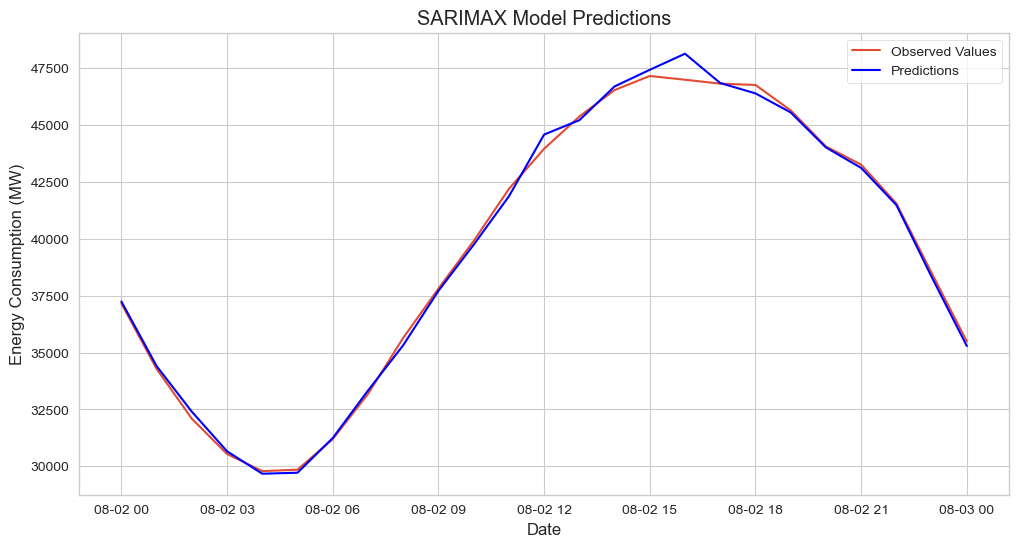

In [28]:
def evaluate_time_series_model(model, order, seasonal_order=None, verbose=True):


    # Initialize lists for predictions and history
    preds = []
    history = train_series.tolist()

    # Fit the specified model and make predictions
    for t in range(len(test_series)):
        if model == 'ARIMA':
            model_fit = ARIMA(history, 
                              order=order).fit() # order=(p, d, q)

        elif model == 'SARIMAX':
            model_fit = SARIMAX(history, 
                                order=order, # order=(p, d, q)
                                seasonal_order=seasonal_order, # seasonal_order=(P, D, Q, s)
                                enforce_stationarity=False, 
                                enfore_invertibility=False).fit() 

        output = model_fit.forecast()
        preds.append(output[0])
        history.append(test_series.iloc[t])

        if verbose:
            print(f'Completed iteration {t+1}/{len(test_series)}')

    # Create a Series for predictions
    pred_series = pd.Series(preds, index=test_series.index)

    # Calculate Mean Squared Error and r2 score
    rmse = mean_squared_error(test_series, pred_series, squared=False)
    r2 = r2_score(test_series, pred_series)
    print(f'Root Mean Squared Error (MSE): {rmse:.3f}')
    print(f'R Squared Score (r2): {r2:.3f}')

    # Plot observed values and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_series, label='Observed Values')
    plt.plot(pred_series, color='blue', label='Predictions')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'{model} Model Predictions')
    plt.show()

# SARIMAX time series model with order=(1,1,0), seasonal_order=(1,1,0,24)
evaluate_time_series_model(model='SARIMAX', order=(1,1,0), seasonal_order=(1,1,0,24), verbose=True)

Given the computational complexity and a desire to optimize time efficiency, the training data utilized in this analysis was confined to the period from January 1, 2017, to August 2, 2018. The subsequent testing set encompassed the date range from August 2, 2018, to August 3, 2018. An evaluation of the model's performance reveals exceptional results, with a remarkably low Root Mean Squared Error (RMSE) of 316.222 and a high R-squared (R²) score of 0.997, signifying the model's strong predictive accuracy.

<!-- While the SARIMA model exhibited exceptional performance, its inherent limitation was its computational slowness in conducting one-step forecasting. Given the complexity of machine learning models, which typically involve extensive training times, a divergent approach will be explored. Although machine learning models may provide alternative forecasting strategies, it is anticipated that their predictive performance may not match that of the SARIMA model. -->

#### ML Model Architecture:

Time series forcasting using Machine Learning models has its own challenges, however, there are multiple models we can investigate. These models are as follows:

1. Exponential Smoothing:
Exponential Smoothing is a classical and widely used time series forecasting method. It incorporates weighted averages of past observations to make predictions. Exponential Smoothing models include Single Exponential Smoothing (SES), Double Exponential Smoothing (Holt's method), and Triple Exponential Smoothing (Holt-Winters method). These models are particularly useful for capturing different types of trends and seasonality within time series data.
    - Pros:
        - Effective at capturing seasonality and trend patterns.
        - Simplicity and ease of use.
    - Cons:
        - Limited ability to handle complex data with multiple seasonal patterns.

    Exponential Smoothing, despite its simplicity, may not be the optimal choice when compared to the BL (Base Model) due to the presence of intricate and multi-dimensional seasonal patterns within our dataset, encompassing daily, monthly, quarterly, and other periodicities. Additionally, the adoption of advanced Exponential Smoothing variants, such as Triple Exponential Smoothing, could introduce substantial time and computational costs. Consequently, for this specific forecasting task, Exponential Smoothing models will not be considered as primary contenders against the Base Model.

2. Prophet:
Prophet is an open-source forecasting tool developed by Facebook. It is designed to handle time series data with daily observations that display patterns on different time scales. Prophet is user-friendly, as it requires minimal data preprocessing and manual adjustments. It can effectively model various seasonal patterns, holidays, and special events in time series data.
    - Pros:
        - Incorporates holidays, special events, and multiple seasonalities.
        - Robust to missing data and outliers.
        - User-friendly with automatic component selection.
    - Cons:
        - May not perform as well with data that lacks clear patterns.

    Prophet emerges as a strong contender compared to the Base Model (BL) due to its ability to effectively capture a multitude of seasonal patterns, spanning hourly, daily, weekly, and more, a feature notably absent in the ARIMA models. Additionally, Prophet's proficiency in incorporating holidays as influential factors and its built-in capability to identify outliers within the dataset make it a versatile and advantageous choice for time series forecasting.

3. Long Short-Term Memory (LSTM):
LSTM is a type of recurrent neural network (RNN) that has demonstrated exceptional capabilities in sequence modeling and time series forecasting. LSTMs can capture long-range dependencies in data and are particularly suitable for tasks with complex temporal patterns. They are often used in scenarios where memory of past observations is essential for making accurate predictions.
    - Pros:
        - Ability to capture intricate temporal dependencies.
        - Suitable for non-linear and complex time series.
    - Cons:
        - Requires substantial data and computational resources.
        - Prone to overfitting when not properly tuned.

    LSTMs can effectively model and predict consumption patterns. These models also accommodate sequences of varying lengths, which is crucial for handling irregular or gapped data points common in real-world energy datasets. LSTMs represent a powerful and adaptive choice for time series analysis against my BL model.

4. Ensemble Models (e.g., XGBoost):
Ensemble models like XGBoost excel in aggregating the outputs of multiple base models to enhance predictive accuracy. When applied to time series forecasting, ensemble methods can effectively combine the strengths of different models to achieve superior results.
    - Pros:
        - Exceptional predictive performance by combining multiple models.
        - Robust against outliers and noise in the data.
    - Cons:
        - Can be computationally intensive and may require longer training times.
        - Parameter tuning can be challenging.

    XGBoost's predictive power, scalability, robustness, and interpretability make it a strong contender for energy consumption time series analysis.

While a theoretical comparison of models provides valuable insights, the true assessment of their performance lies in real-world experiments. To expedite the evaluation process, two machine learning models—LSTM and XGBoost—will be developed and rigorously tested, allowing for a direct comparison of their performance. These models will then be benchmarked against the Base Model, providing a comprehensive and practical analysis of their effectiveness in addressing the specific challenges of energy consumption time series forecasting.

##### XGBoost

In [29]:
# Tran & Test Split
split_date = '2018-08-02 00:00:00'

# Create training and testing dataframes
train_df = df_raw.loc[df_raw.index <= split_date].copy()
test_df = df_raw.loc[df_raw.index > split_date].copy()

X_train, y_train = feature_creation(train_df, label='Power_MWH')
X_test, y_test = feature_creation(test_df, label='Power_MWH')

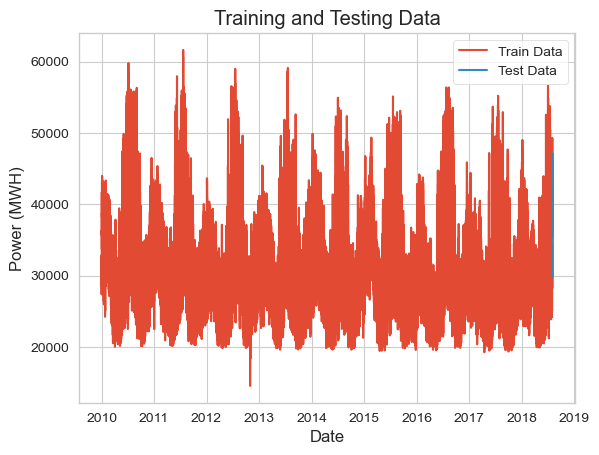

In [30]:
plt.plot(train_df.index, train_df['Power_MWH'], label='Train Data')
plt.plot(test_df.index, test_df['Power_MWH'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Power (MWH)')
plt.legend()
plt.title('Training and Testing Data')
plt.show()

In [31]:
# Performing a grid search for hyper parameter tuning
reg = xgb.XGBRegressor()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 500],  
    'max_depth': [2, 3, 6],  
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best hyperparameters: {'max_depth': 3, 'n_estimators': 50}


The importance of each feature in training: 


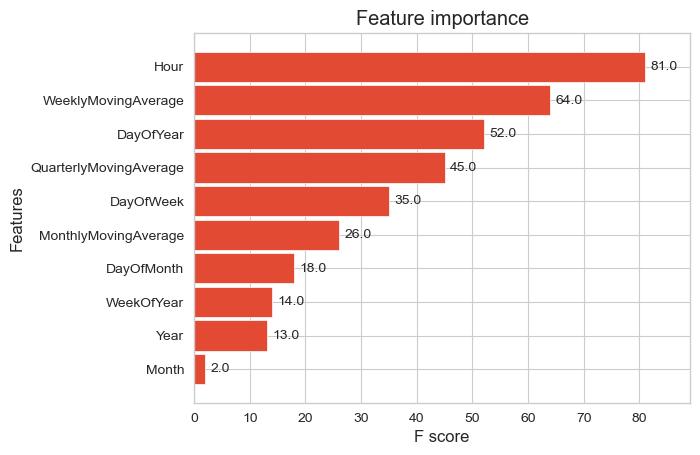

In [32]:
# XGBoost model
reg = xgb.XGBRegressor(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'])
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

print('The importance of each feature in training: ')
_ = plot_importance(reg, height=0.9)

The visual representation above illustrates the significance of each feature in training an XGBoost model. This valuable insight can be leveraged to enhance the model's performance through activities such as feature selection or additional experimentation with feature engineering.

In [33]:
# Plot the 'Power_MWH' and 'Power_MWH_Prediction'
test_df['Power_MWH_Prediction'] = reg.predict(X_test)

rmse = mean_squared_error(test_df['Power_MWH'], test_df['Power_MWH_Prediction'], squared=False)
r2 = r2_score(test_df['Power_MWH'], test_df['Power_MWH_Prediction'])
print(f'Root Mean Squared Error (MSE): {rmse:.3f}')
print(f'R Squared Score (r2): {r2:.3f}')

Root Mean Squared Error (MSE): 1419.481
R Squared Score (r2): 0.946


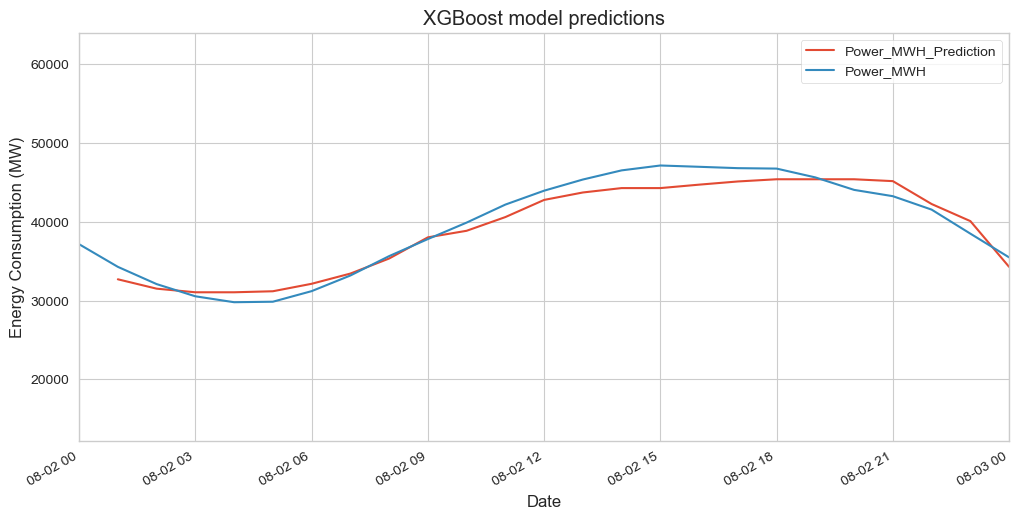

In [34]:
# Plot the 'Power_MWH' and 'Power_MWH_Prediction' for the first 2 weeks of Jul and Jan
ap_concat = pd.concat([test_df, train_df], sort=False)

fig, ax = plt.subplots(figsize=(12, 6))
_ = ap_concat[['Power_MWH_Prediction','Power_MWH']].plot(ax=ax)
plt.xlim('08-02-2018', '08-03-2018')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('XGBoost model predictions')
plt.legend()
plt.show()

In this section, an XGBoost model was trained and evaluated after thorough hyperparameter tuning. The model demonstrated commendable performance, as evidenced by the following evaluation metrics:

- Root Mean Squared Error (RMSE): 1419.481
- R Squared Score (r2): 0.946

Upon comparing this model's performance to the base model, it is evident that the base model excels in predicting the future value one day in advance. However, it is worth noting that the base model's efficiency is significantly lower. For tasks involving time series analysis across multiple days in advance and large datasets, XGBoost emerges as a more suitable and efficient choice when compared to the base model. 

##### LSTM:

In [35]:
# Train & Test splits
np.random.seed(73)
train_start_date = datetime(2016, 1, 1)
train_end_date = datetime(2018, 8, 2)


# Split the data into training and testing
train_series = df.loc[(df.index >= train_start_date) & (df.index < train_end_date), 'Power_MWH']
test_series = df.loc[(df.index >= train_end_date), 'Power_MWH']
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_values = scaler.fit_transform(train_series.values.reshape(-1,1))
train_series_scaled = pd.Series(data=scaled_train_values.reshape(1,-1)[0], index=train_series.index)

In [36]:
# LSTM parameters
n_input = 24
n_features= 1
sampling_rate = 1
stride = 1
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train_values, 
                                      scaled_train_values, 
                                      length=n_input,
                                      sampling_rate=sampling_rate,
                                      stride=stride,
                                      batch_size=batch_size)

# LSTM model architecture
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_input, n_features)))
model.add(Dense(1))

# Compile and fit
model.compile(optimizer='adam', loss='mse')
model.fit(train_generator, epochs=2)

# Generate predictions
lstm_preds = []

# Initialize the current batch with the last n_input values from the scaled training data
current_batch = scaled_train_values[-n_input:].reshape((1, n_input, n_features))

# Generate predictions for each step in the test_series
for _ in range(len(test_series)):
    pred = model.predict(current_batch)[0]  
    lstm_preds.append(pred) 
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)
    
# Evaluate performance   
lstm_preds = scaler.inverse_transform(lstm_preds)
lstm_preds = [item for sublist in lstm_preds for item in sublist]
    
rmse = mean_squared_error(test_series.values, lstm_preds, squared=False)
r2 = r2_score(test_series.values, lstm_preds)
print(f'Root Mean Squared Error (MSE): {rmse:.3f}')
print(f'R Squared Score (r2): {r2:.3f}')

Epoch 1/2
22632/22632 [==============================] - 167s 7ms/step - loss: 0.0027
Epoch 2/2
1/1 [==============================] - 0s 30ms/step
Root Mean Squared Error (MSE): 1770.087
R Squared Score (r2): 0.914


Text(0.5, 1.0, 'LSTM Forecasts')

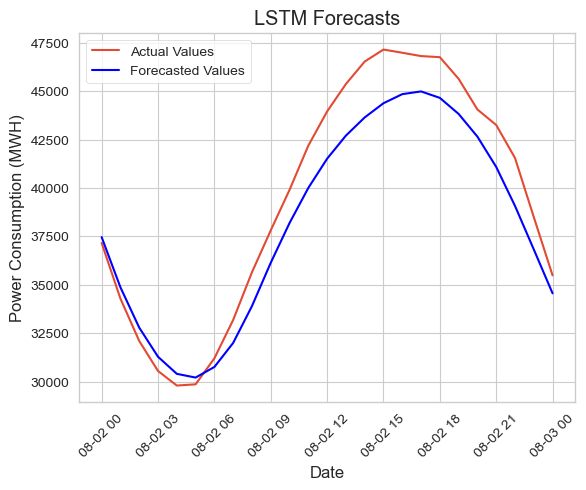

In [37]:
# Plot the Actual and forcasted values for the test data (LSTM)
LSTM_preds_series = pd.Series(lstm_preds, index=test_series.index)

plt.plot(test_series, label='Actual Values')
plt.plot(LSTM_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Power Consumption (MWH)')
plt.legend()
plt.xticks(rotation=45) 
plt.title('LSTM Forecasts')

In this section, an LSTM model was trained and evaluated for two epochs using data from 2016 to 2018. The model demonstrated a great performance, as evidenced by the following evaluation metrics:

Root Mean Squared Error (RMSE): 1770.087
R Squared Score (r2): 0.914

Upon comparing LSTM's performance to the base model and the XGBoost, LSTM model has shown the best performance as it reached to 91% R Squared Score after training for only 2 epochs and using data from the years of 2016 to 2018. Upon training this model for more itterations and more data with proper hyper parameter optimization, this model will beat XGBoost on performance and SARIMA on efficiency and speed. 

### Conclusions and Future Directions:
---

This task has been successfully accomplished by identifying an effective model for predicting power consumption one day into the future. The Power Consumption dataset proved to be of good quality, with only minor challenges, including missing values and duplicates. While the dataset could have undergone further analysis, such as outlier detection, due to time constraints, a significant portion of the effort was dedicated to data visualization and exploratory data analysis.

Several temporal features, such as hour, day, month, year, and quarter, were created, and various graphs were generated to gain a deeper understanding of the dataset's nature. Time series analysis can be complex, involving the identification of underlying components like trends, seasonality, and residuals. To determine whether the dataset was stationary and whether a Moving Average component was required for base model development, various statistical tests such as the Augmented Dickey-Fuller test were employed, alongside the creation of plots like ACF and PACF.

Ultimately, SARIMA was chosen as the base model for this problem, without the inclusion of a Moving Average component, as the dataset exhibited stationarity. However, additional research into multiple ML models was conducted, leading to the testing of two models, namely XGBoost and LSTM. The comparison of these models in a one-day future prediction task revealed that LSTM outperformed the others in terms of both accuracy and speed. Nonetheless, further analysis and optimization are recommended, time permitting.

For future directions and recommendations, it is advisable to explore the inclusion of additional features, such as holidays and weather data, for ML model development. Experimentation with various base model configurations, including ARIMA with different seasonal components, is also encouraged. Furthermore, advanced hyperparameter optimization could enhance the LSTM model's performance.

In conclusion, thank you for taking the time to review this notebook. Please feel free to reach out with any questions or inquiries you may have.